In [ ]:
from __future__ import annotations
from typing import Any, cast
from dataclasses import dataclass
import jax
import jax.numpy as jnp
from jax.tree_util import register_dataclass
import flax.linen as nn
import matplotlib.pyplot as plt
import optax

import hodel


class Encoder(nn.Module):
    """Pixels to prototype."""

    hidden_size: int
    prototype_size: int

    @nn.compact
    def __call__(self, pixels):
        x = nn.leaky_relu(nn.Dense(self.hidden_size)(pixels))
        x = nn.Dense(self.prototype_size)(x)
        return x


class Classifier(nn.Module):
    """Prototype to one-hot output."""

    hidden_size: int
    class_size: int

    @nn.compact
    def __call__(self, prototype):
        x = nn.leaky_relu(nn.Dense(self.hidden_size)(prototype))
        x = nn.Dense(self.class_size)(x)
        return x


class Decoder(nn.Module):
    """Prototype to pixels."""

    hidden_size: int
    pixel_size: int

    @nn.compact
    def __call__(self, prototype):
        x = nn.leaky_relu(nn.Dense(self.hidden_size)(prototype))
        x = nn.sigmoid(nn.Dense(self.pixel_size)(x))
        return x


@register_dataclass
@dataclass
class MNISTParams:
    encoder_params: Any  # Flax params dict
    classifier_params: Any  # Flax params dict
    decoder_params: Any  # Flax params dict
    prototypes: jax.Array  # Latent


def create_mnist_params(key, hidden_size=256, prototype_size=64):
    """Initialize all parameters."""
    keys = jax.random.split(key, 5)

    # Create modules
    encoder_module = Encoder(hidden_size, prototype_size)
    classifier_module = Classifier(hidden_size, 10)
    decoder_module = Decoder(hidden_size, 784)

    # Initialize with dummy inputs
    dummy_pixels = jnp.zeros(784)
    dummy_prototype = jnp.zeros(prototype_size)

    encoder_params = encoder_module.init(keys[0], dummy_pixels)
    classifier_params = classifier_module.init(keys[1], dummy_prototype)
    decoder_params = decoder_module.init(keys[2], dummy_prototype)

    # Initialize prototypes: (10, 64)
    prototypes = jax.random.normal(keys[3], (10, prototype_size)) * 0.1

    return MNISTParams(
        encoder_params=encoder_params,
        classifier_params=classifier_params,
        decoder_params=decoder_params,
        prototypes=prototypes,
    )


@register_dataclass
@dataclass
class MNISTAux:
    image: jax.Array


@dataclass
class MNIST:
    """
    MNIST Energy

    Classification:
    xb: pixels
    xf: one-hot class
    """

    encoder: nn.Module
    classifier: nn.Module
    decoder: nn.Module

    def get_energy(
        self,
        xf: jax.Array,
        xb: Any = None,
        Theta: MNISTParams | None = None,
        aux: MNISTAux | None = None,
    ) -> jax.Array:
        if Theta is None or aux is None:
            raise ValueError("MNIST requires parameters and aux!")
        pixels = xb
        class_logits = xf
        return self._joint_energy(pixels, class_logits, Theta)

    def _joint_energy(
        self, pixels: jax.Array, class_logits: jax.Array, Theta: MNISTParams
    ) -> jax.Array:
        """Compute energy measuring pixel-class consistency."""

        # RECOGNITION PATH: pixels → z_enc → class_pred
        z_enc = cast(jax.Array, self.encoder.apply(Theta.encoder_params, pixels))
        class_pred = cast(
            jax.Array, self.classifier.apply(Theta.classifier_params, z_enc)
        )
        recognition_error = jnp.sum((class_pred - class_logits) ** 2)

        # GENERATION PATH: class → z_dec → pixels_pred
        class_probs = jax.nn.softmax(class_logits)
        z_dec = class_probs @ Theta.prototypes  # (10,) @ (10, 64) → (64,)
        pixels_pred = cast(jax.Array, self.decoder.apply(Theta.decoder_params, z_dec))
        generation_error = jnp.sum((pixels_pred - pixels) ** 2)

        # LATENT CONSISTENCY: z_enc should match z_dec
        latent_consistency = jnp.sum((z_enc - z_dec) ** 2)

        # CLASS PRIOR: encourage discrete (low entropy)
        class_probs = jax.nn.softmax(class_logits)
        entropy = -jnp.sum(class_probs * jnp.log(class_probs + 1e-8))

        # Weighted sum of terms
        energy = (
            generation_error
            + recognition_error
            + 0.5 * latent_consistency
            + 0.1 * entropy
        )
        return energy


def from_aux(lambda_: jax.Array, aux: MNISTAux) -> jax.Array:
    """Load image from aux."""
    return jnp.asarray(aux.image, dtype=jnp.float32)

def cre_loss(x:jax.Array, x_star: jax.Array, Theta: MNISTParams) -> jax.Array:
    return cast(jax.Array, optax.softmax_cross_entropy(x, x_star))


hidden_size = 256
prototype_size = 64
key = jax.random.PRNGKey(0)

encoder_module = Encoder(hidden_size, prototype_size)
classifier_module = Classifier(hidden_size, 10)
decoder_module = Decoder(hidden_size, 784)
theta = create_mnist_params(key, hidden_size, prototype_size)
energy_model = MNIST(encoder_module, classifier_module, decoder_module)
sim = hodel.HODEL(energy_model.get_energy, get_xb_fn=from_aux, loss_fn=cre_loss)

In [ ]:
from torchvision.datasets import MNIST
import numpy as np


def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


def flatten_and_cast(pic):
    """Convert PIL image to flat (1-dimensional) numpy array."""
    return np.ravel(np.array(pic, dtype=jnp.float32))


# Define our dataset, using torch datasets
mnist_dataset = MNIST("/tmp/mnist/", download=True, transform=flatten_and_cast)
n_targets = 10

# Get the full train dataset
train_images = jnp.array(mnist_dataset.data, dtype=jnp.float32).reshape(
    len(mnist_dataset.data), -1
)
train_labels = one_hot(jnp.array(mnist_dataset.targets), n_targets)
train_aux = jax.vmap(lambda image_: MNISTAux(image_))(train_images)
train_xf_stars = jnp.expand_dims(train_labels, 1) # middle axis for lambda index

# Get full test dataset
mnist_dataset_test = MNIST("/tmp/mnist/", download=True, train=False)
test_images = jnp.array(
    mnist_dataset_test.data.reshape(len(mnist_dataset_test.data), -1), dtype=jnp.float32
)
test_labels = one_hot(jnp.array(mnist_dataset_test.targets), n_targets)
test_aux = jax.vmap(lambda image_: MNISTAux(image_))(test_images)
test_xf_stars = jnp.expand_dims(test_labels, 1)

# Dim check
print(train_aux.image.shape, train_xf_stars.shape)

(60000, 784) (60000, 1, 10)


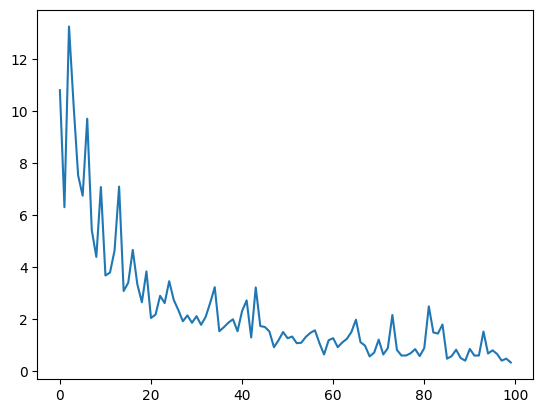

In [3]:
lr = 1e-3

final_theta, L = sim.batch_learn(
    jnp.array([0.0]),
    jnp.zeros(10),
    train_xf_stars,
    theta,
    train_aux,
    batch_size=64,
    optim=optax.adam(lr),
    nepochs=100,
)

plt.plot(L)
plt.show()

In [4]:
predictions = jax.vmap(lambda aux: 
    sim.solve(jnp.array([0.0]), jnp.zeros(10), final_theta, aux)
)(test_aux)
# Compute accuracy
pred_classes = jnp.argmax(predictions, axis=-1)
true_classes = jnp.argmax(test_xf_stars.squeeze(), axis=-1)
accuracy = jnp.mean(pred_classes == true_classes)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 96.60%


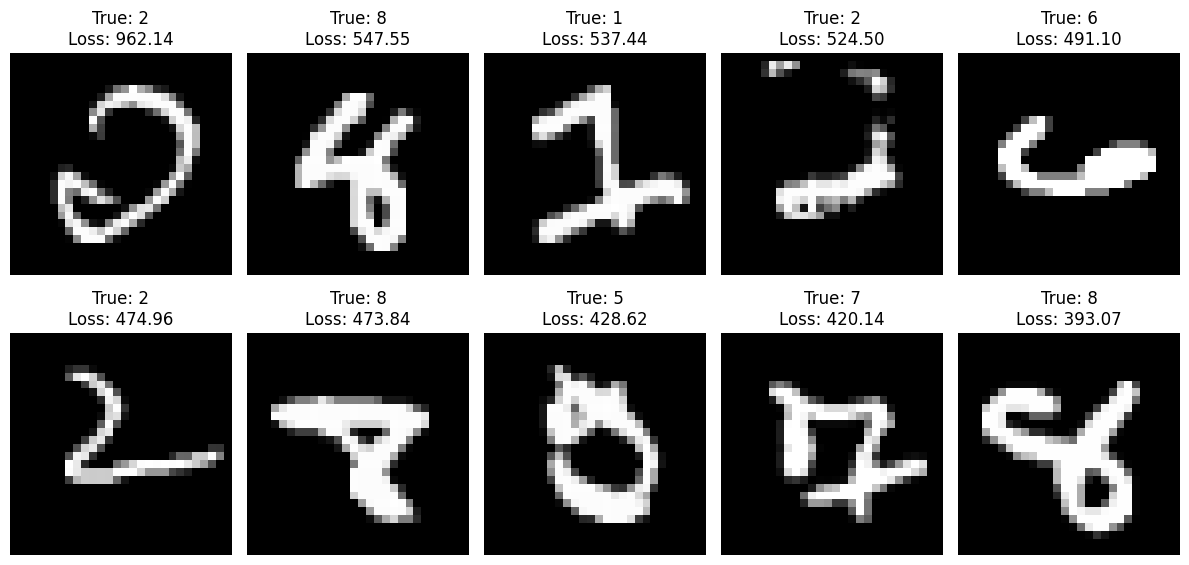

In [34]:
# Find the hardest samples
losses = []
for i in range(len(test_images)):
    loss = sim.loss(jnp.array([0.0]), jnp.zeros(10), test_xf_stars[i], 
                    final_theta, MNISTAux(test_images[i]))
    losses.append((i, float(loss[0])))

# Sort by loss
losses.sort(key=lambda x: x[1], reverse=True)

# Visualize top 10 hardest samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for idx, (sample_idx, loss_val) in enumerate(losses[:10]):
    img = test_images[sample_idx].reshape(28, 28)
    true_label = jnp.argmax(test_xf_stars[sample_idx])
    
    axes[idx//5, idx%5].imshow(img, cmap='gray')
    axes[idx//5, idx%5].set_title(f'True: {true_label}\nLoss: {loss_val:.2f}')
    axes[idx//5, idx%5].axis('off')
plt.tight_layout()
plt.show()

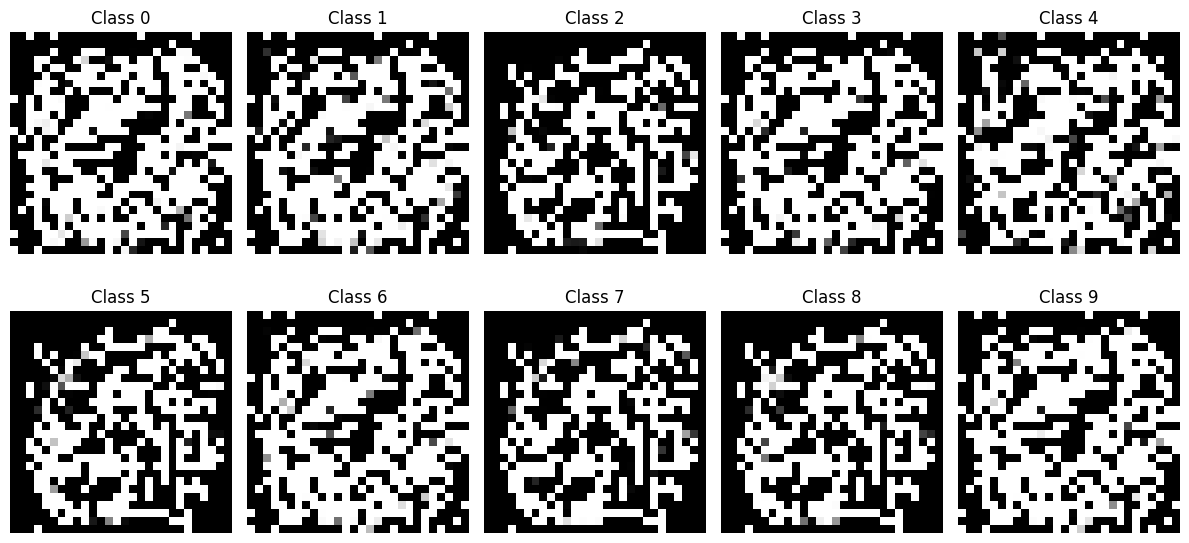

In [37]:
# Generate prototypical images for all 10 classes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for class_idx in range(10):
    # Get the prototype embedding for this class
    z_prototype = final_theta.prototypes[class_idx]  # Shape: (64,)
    
    # Decode to pixels
    prototype_image = decoder_module.apply(final_theta.decoder_params, z_prototype)
    
    # Visualize
    ax = axes[class_idx // 5, class_idx % 5]
    ax.imshow(prototype_image.reshape(28, 28), cmap='gray')
    ax.set_title(f'Class {class_idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Step 0, Energy: 293.7254
Step 100, Energy: 133.6112
Step 200, Energy: 138.5627
Step 300, Energy: 157.0461
Step 400, Energy: 149.7239
Step 500, Energy: 134.2387
Step 600, Energy: 197.6824
Step 700, Energy: 135.7744
Step 800, Energy: 134.2076
Step 900, Energy: 135.6733
Step 0, Energy: 280.0086
Step 100, Energy: 151.4140
Step 200, Energy: 232.9677
Step 300, Energy: 155.4950
Step 400, Energy: 289.1532
Step 500, Energy: 185.0961
Step 600, Energy: 177.7083
Step 700, Energy: 152.8747
Step 800, Energy: 294.3217
Step 900, Energy: 156.4165
Step 0, Energy: 162.7345
Step 100, Energy: 127.8159
Step 200, Energy: 135.5220
Step 300, Energy: 129.8796
Step 400, Energy: 127.9235
Step 500, Energy: 131.4924
Step 600, Energy: 127.2125
Step 700, Energy: 130.0370
Step 800, Energy: 130.2032
Step 900, Energy: 128.7283
Step 0, Energy: 275.9716
Step 100, Energy: 144.8600
Step 200, Energy: 143.7033
Step 300, Energy: 152.5314
Step 400, Energy: 140.0644
Step 500, Energy: 145.0815
Step 600, Energy: 143.0778
Step 700,

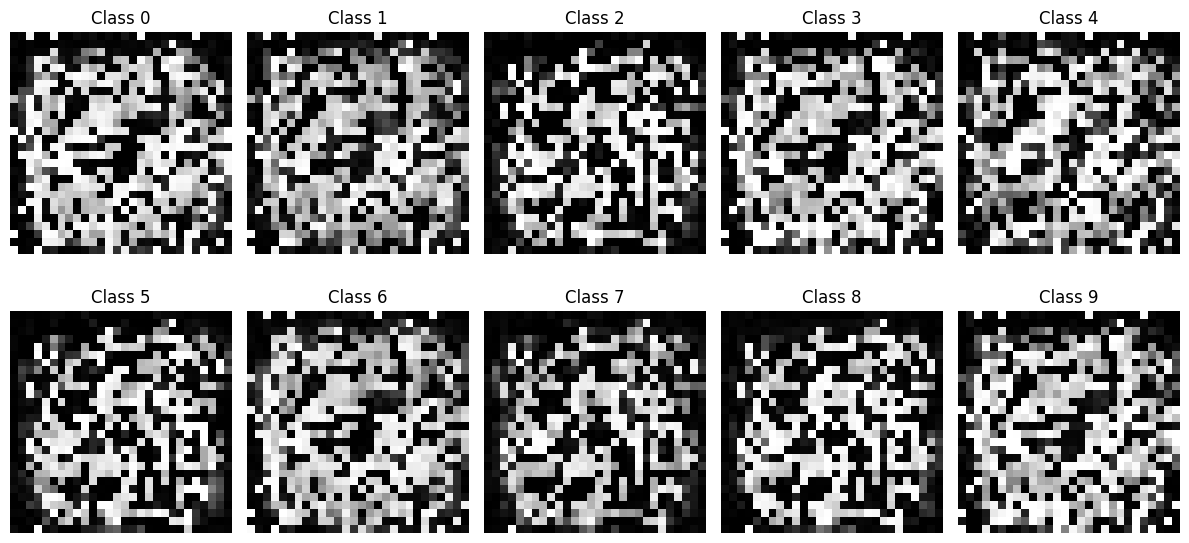

In [36]:
def generate_class_prototype(class_idx, Theta, n_steps=1000, lr=0.01):
    """Generate a prototypical image by minimizing energy w.r.t. pixels."""
    
    # Fix class to high-confidence one-hot
    class_logits = jnp.zeros(10).at[class_idx].set(10.0)  # Very confident
    
    # Start from decoder output
    z_proto = Theta.prototypes[class_idx]
    pixels = decoder_module.apply(Theta.decoder_params, z_proto)
    
    # Energy function to minimize w.r.t. pixels
    def energy_fn(pix):
        aux = MNISTAux(pix)
        return energy_model.get_energy(class_logits, pix, Theta, aux)
    
    # Gradient descent on pixels
    for step in range(n_steps):
        grad = jax.grad(energy_fn)(pixels)
        pixels = pixels - lr * grad
        pixels = jnp.clip(pixels, 0., 1.)  # Keep in valid range
        
        if step % 100 == 0:
            energy = energy_fn(pixels)
            print(f"Step {step}, Energy: {energy:.4f}")
    
    return pixels

# Generate all classes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for class_idx in range(10):
    pixels = generate_class_prototype(class_idx, final_theta)
    
    ax = axes[class_idx // 5, class_idx % 5]
    ax.imshow(pixels.reshape(28, 28), cmap='gray')
    ax.set_title(f'Class {class_idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

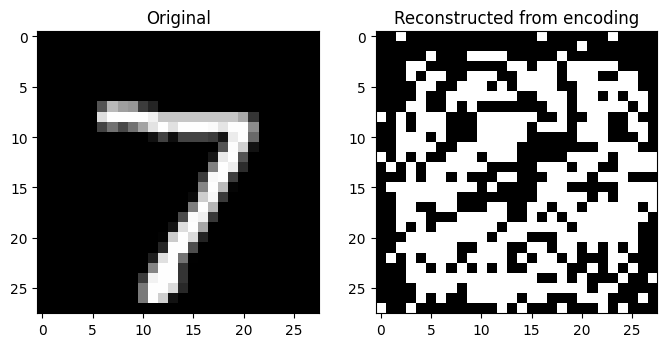

In [38]:
# Visualize what happens when we decode the ENCODED representation
test_img = test_images[0]
z_enc = encoder_module.apply(final_theta.encoder_params, test_img)
reconstructed = decoder_module.apply(final_theta.decoder_params, z_enc)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(test_img.reshape(28, 28), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(reconstructed.reshape(28, 28), cmap='gray')
axes[1].set_title('Reconstructed from encoding')
plt.show()